# Shape Analysis of Cancer Cells

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [1]:
from decimal import Decimal
import matplotlib.pyplot as plt
import os
import geomstats.backend as gs
from scipy.integrate import simpson
from nsimplices import *
from common import *
from scipy.stats import wasserstein_distance
import scipy.stats as stats

gs.random.seed(2021)

In [2]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'breast_cancer'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
rescale = True
print(f"Will save figs to {figs_dir}")


Will save figs to /home/wanxinli/dyn/dyn/saved_figs/breast_cancer


# 2. Dataset Description

We study a dataset of breast cancer image. 

MCF7 is a breast cancer cell line with low metastatic potential.

MDA_MD_231 is a highly metastatis breast cancer line. 

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [3]:
def load_breast_cancer_cells():
    """Load dataset of mutated retinal cells.

    The cells are grouped by mutation in the dataset :
    - the *control* cells are ARPE19,
    - the cells treated with Akt mutation,
    - and the ones treated with Mek mutation
    - and the cells treated with the Ras mutation.

    Additionally, in each of these classes, the cells are cultured on two surfaces :
    - the *GDA* cells (simple glass)
    - the *FN* ones (Fibronectin coated glass).
    
    Returns
    -------
    cells : array of n_cells planar discrete curves
        Each curve represents the boundary of a cell in counterclockwise order.
        Their barycenters are fixed at 0 (translation has been removed).
        Their lengths are not necessarily equal (scaling has not been removed).
    lines : list of n_cells strings
        List of the cell lines 

    """

    cell_path = os.path.join(data_path, "breast_cancer", "cells.txt")
    lines_path = os.path.join(data_path, "breast_cancer", "lines.txt")

    with open(cell_path) as cells_file:
        cells = cells_file.read().split("\n\n")
    for i, cell in enumerate(cells):
        cell = cell.split("\n")
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.cast(gs.array(curve), gs.float32)
    with open(lines_path) as lines_file:
        lines = lines_file.read().split("\n")
    
    # remove the last blank cell
    cells = cells[:-1]
    lines = lines[:-1]
    return cells, lines

In [4]:
cells, lines = load_breast_cancer_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 677


This is shown by displaying the unique elements in the lists `lines`:

In [5]:
import pandas as pd

LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['MCF10A' 'MCF7' 'MDA_MB_231']


Before using the dataset, we check for duplicates in the dataset.

We compute the pairwise distance between two cells. If the pairwise distance is smaller than 0.1, we visualize the corresponding cells to check they are duplicates.

In [6]:
tol = 1e-1
for i, cell_i in enumerate(cells):
    for j, cell_j in enumerate(cells):
        if i != j and cell_i.shape[0] == cell_j.shape[0]:
            dist = np.sum(np.sqrt(np.sum((cell_i-cell_j)**2,axis=1)))
            if dist < tol:
                print(f"cell indices are: {i} and {j}, {lines[i]}, {lines[j]}")

There are no duplicates in the breast cancer dataset.

The size of each class is displayed below:

In [7]:
ds = {}

n_cells_arr = gs.zeros(3)


for j, line in enumerate(LINES):
    to_keep = gs.array(
        [
            one_line == line
            for one_line in lines
        ]
    )
    ds[line] = [
        cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
    ]
    nb = len(ds[line])
    print(f"{line}: {nb}")
    n_cells_arr[j] = nb

print({'MCF10A': n_cells_arr[0], 'MCF7': n_cells_arr[1], 'MDA_MB_231': n_cells_arr[2]})
n_cells_df = pd.DataFrame({'MCF10A': [n_cells_arr[0]], 'MCF7': [n_cells_arr[1]], 'MDA_MB_231': [n_cells_arr[2]]})

display(n_cells_df)

MCF10A: 228
MCF7: 225
MDA_MB_231: 224
{'MCF10A': 228.0, 'MCF7': 225.0, 'MDA_MB_231': 224.0}


,MCF10A,MCF7,MDA_MB_231
0,228.0,225.0,224.0


We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [8]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for line in LINES:
        output_list = []
        for one_cell in input_ds[line]:
            output_list.append(func(one_cell))
        output_ds[line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [9]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(443.8, 580.2, 454.9, 567.1)

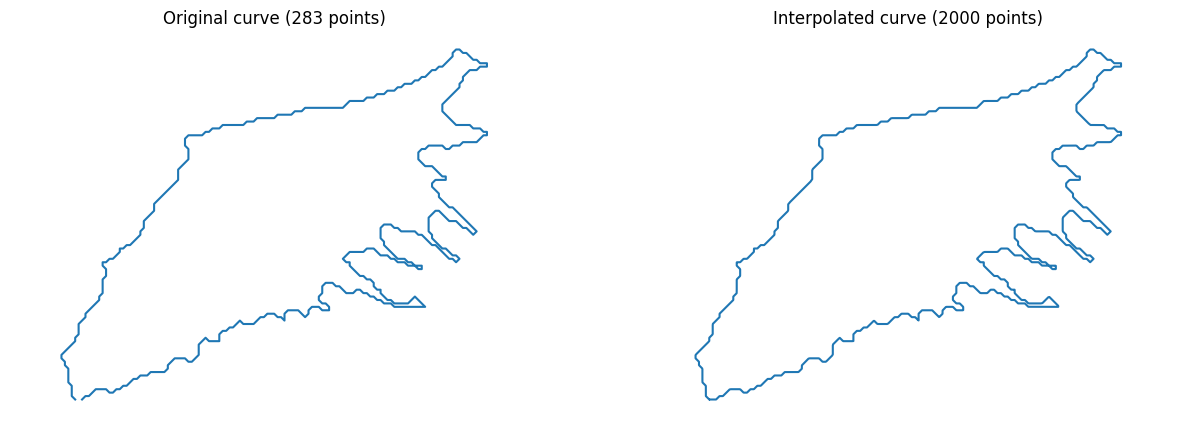

In [10]:
k_sampling_points = 2000
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
# plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [11]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

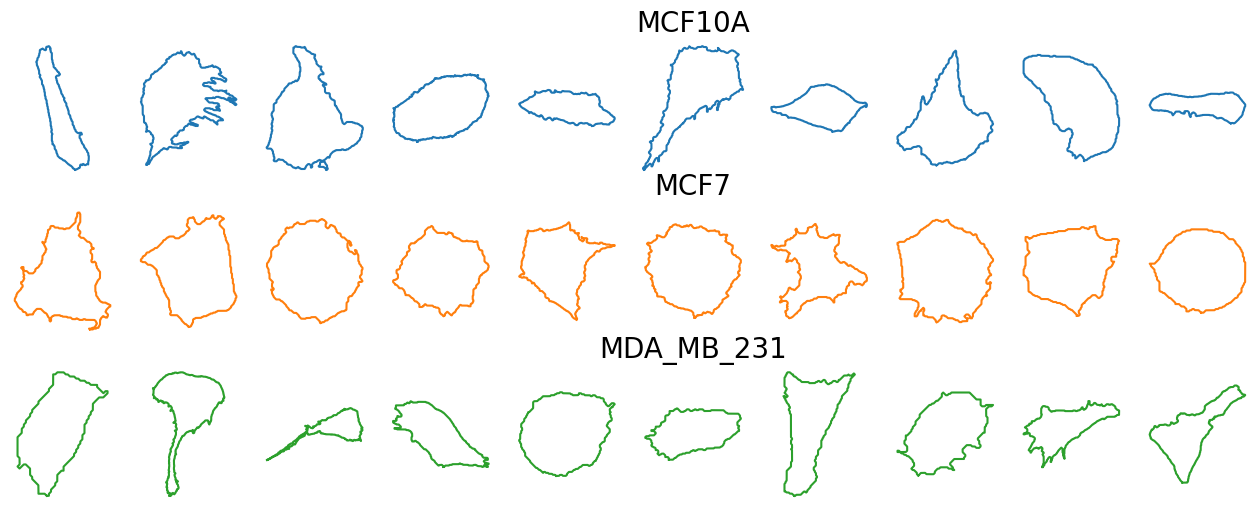

In [12]:
n_cells_to_plot = 10
radius = 170

fig = plt.figure(figsize=(16, 6))
count = 1
for i, line in enumerate(LINES):
    cell_data = ds_interp[line]
    for i_to_plot in range(n_cells_to_plot):
        cell = gs.random.choice(cell_data)
        fig.add_subplot(3, n_cells_to_plot, count)
        count += 1
        plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
        plt.xlim(-radius, radius)
        plt.ylim(-radius, radius)
        plt.axis("equal")
        plt.axis("off")
        if i_to_plot == n_cells_to_plot // 2:
            plt.title(f"{line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

Visual inspection of these curves seems to indicate more protusions appearing in MDA_MB_231 cells, compared with MCF7. 

### Remove duplicate samples in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [13]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [14]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`, as shown below. Details on Kendall shape spaces can be found in the [module implementing them](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pre_shape.py) or the notebooks using them. 

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). This exhaustive search is implemented in the function `exhaustive_align` below.

We perform the pre-shape projection and the exhaustive alignment of the cells against the base curve, which is chosen to be the first cell curve of the dataset, called `BASE_CURVE`. 

Both the projection and the alignment make use of our auxiliary function `apply_func_to_ds`, which finally outputs a dataset of cell curves organized within a dictionnary called `ds_align`.

Load aligned cells from txt files. These files were generated by calling `align` function in `common.py`.

In [15]:
aligned_base_folder = os.path.join(data_path, dataset_name, "aligned")

ds_align = {}

for metric in METRICS:
    ds_align[metric] = {}
    if metric == 'SRV':
        aligned_folder = os.path.join(aligned_base_folder, 'no_rescale')
    elif metric == 'Linear':
        aligned_folder = os.path.join(aligned_base_folder, 'no_rescale_no_reparameterization')

    for line in LINES:
        ds_align[metric][line] = []
        cell_num = len(ds_proc[line])
 
        for i in range(cell_num):
            file_path = os.path.join(aligned_folder, f"{line}_{i}.txt")
            cell = np.loadtxt(file_path)
            ds_align[metric][line].append(cell)
            

Check we did not loss any cells after alignment

In [16]:
for line in LINES:
    for metric in METRICS:
        print(f"{line} using {metric}: {len(ds_align[metric][line])}")

MCF10A using SRV: 228
MCF10A using Linear: 228
MCF7 using SRV: 225
MCF7 using Linear: 225
MDA_MB_231 using SRV: 224
MDA_MB_231 using Linear: 224


We visually evaluate that methods perform correctly, by plotting the results of the projection and the alignment through the following code.

Text(0.5, 1.0, 'Aligned curve')

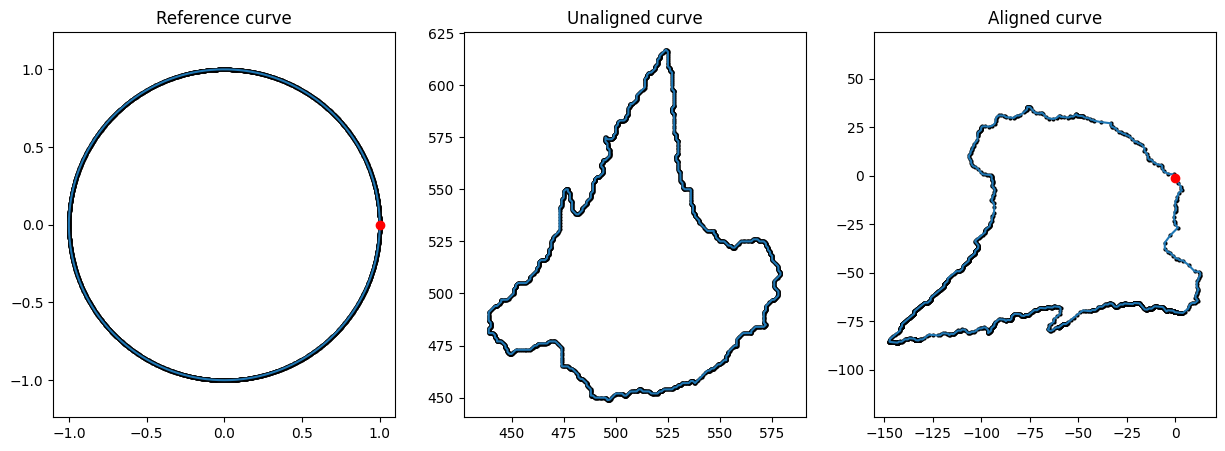

In [17]:
BASE_CURVE = generate_circle_points(k_sampling_points)
index = 29
metric = 'SRV'
unaligned_cell = ds_proc["MCF10A"][index]
aligned_cell = ds_align[metric]["MCF10A"][index]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot([BASE_CURVE[-1, 0], BASE_CURVE[0, 0]], [BASE_CURVE[-1, 1], BASE_CURVE[0, 1]], 'tab:blue')
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4, c='black')
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4, c='black')
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4, c='black')
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

# plt.savefig(os.path.join(figs_dir, "alignment.svg"))
# plt.savefig(os.path.join(figs_dir, "alignment.pdf"))



In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [18]:
CURVES_SPACE_SRV = DiscreteCurvesStartingAtOrigin(ambient_dim=2, k_sampling_points=k_sampling_points)

In [19]:
cell_shapes_list = {}
for metric in METRICS:
    cell_shapes_list[metric] = []
    for line in LINES:
        cell_shapes_list[metric].extend(ds_align[metric][line])

cell_shapes = {}
for metric in METRICS:
    cell_shapes[metric] = gs.array(cell_shapes_list[metric])
print(cell_shapes[metric].shape)

(677, 1999, 2)


Remove outliers using DeCOr-MDS, together for DUNN and DLM8 cell lines.

In [20]:
def linear_dist(cell1, cell2):
    return gs.linalg.norm(cell1 - cell2)

def srv_dist(cell1, cell2):
    CURVES_SPACE_SRV.equip_with_metric(SRVMetric)
    return CURVES_SPACE_SRV.metric.dist(cell1, cell2)
 
# compute pairwise distances
pairwise_dists = {}
metric = 'SRV'
pairwise_dists[metric] = parallel_dist(cell_shapes[metric], srv_dist, k_sampling_points)

metric = 'Linear' 
pairwise_dists[metric] = parallel_dist(cell_shapes[metric], linear_dist, k_sampling_points)


INFO: finding looplift candidates


/home/wanxinli/dyn/dyn/notebooks/common.py:37: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "parallel_dist" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/wanxinli/dyn/dyn/notebooks/common.py (40)

File "common.py", line 40:
def parallel_dist(cells, dist_fun, k_sampling_points):
    <source elided>
    pairwise_dists = np.zeros((cells.shape[0], cells.shape[0]))
    for i in prange(cells.shape[0]):
    ^

  @jit(nopython=False, forceobj=True)


In [21]:
# run DeCOr-MDS
metric = 'Linear'
# dim_start = 2 # we know the subspace dimension is 3, we set start and end to 3 to reduce runtime 
# dim_end = 10
dim_start = 3
dim_end = 3
std_multi = 2
subspace_dim, outlier_indices = find_subspace_dim(pairwise_dists[metric], dim_start, dim_end, std_multi)
print(f"subspace dimension is: {subspace_dim}")
print(f"outlier_indices are: {outlier_indices}")

subspace dimension is: 3
outlier_indices are: [ 18  32  46  49  62  70  72  84  92  97 111 118 119 134 142 146 148 153
 154 173 175 183 197 233 245 246 255 262 287 288 297 300 314 345 352 380
 381 384 388 415 426 436 444 461 467 477 485 486 505 514 519 528 532 539
 543 547 550 553 554 566 579 586 590 597 602 605 606 613 617 633 654 670]


Visualize outlier cells to check if they are artifacts 

Text(0.5, -0.01, '')

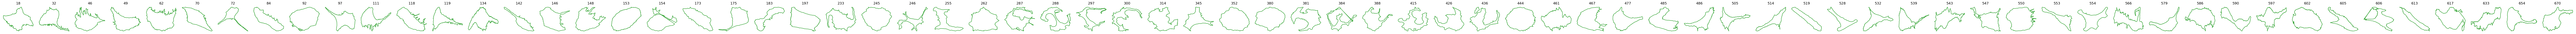

In [22]:
fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(outlier_indices),
    figsize=(2*len(outlier_indices), 2),
)

for i, outlier_index in enumerate(outlier_indices):
    one_cell = cell_shapes[metric][outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "outlier.svg"))

Text(0.5, -0.01, '')

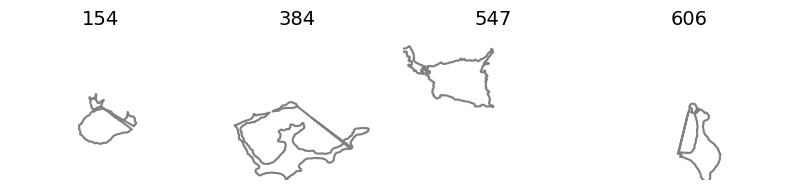

In [23]:
delete_indices = [154, 384, 547, 606]


fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(delete_indices),
    figsize=(2*len(delete_indices), 2),
)


for i, outlier_index in enumerate(delete_indices):
    one_cell = cell_shapes[metric][outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"gray")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # ax.axis("off")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "delete_outlier.svg"))
# plt.savefig(os.path.join(figs_dir, "delete_outlier.pdf"))

After visual inspection, we decide to remove the outlier cells

In [24]:
def remove_ds_one_layer(ds, delete_indices):
    global_i = sum(len(v) for v in ds.values())-1
    for line in reversed(list(ds.keys())):
        line_cells = ds[line]
        for i, _ in reversed(list(enumerate(line_cells))):
            if global_i in delete_indices:
                ds[line] = np.concatenate((ds[line][:i], ds[line][i+1:]), axis=0)
            global_i -= 1

    return ds


def remove_cells_one_layer(cells, cell_shapes, lines, ds_proc, ds_align, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, ds,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    delete_indices = sorted(delete_indices, reverse=True) # to prevent change in index when deleting elements
    
    # Delete elements
    cells = del_arr_elements(cells, delete_indices)
    for metric, _ in cell_shapes.items():
        cell_shapes[metric] = np.delete(np.array(cell_shapes[metric]), delete_indices, axis=0)

    lines = list(np.delete(np.array(lines), delete_indices, axis=0))
    ds_proc = remove_ds_one_layer(ds_proc, delete_indices)
    for metric in METRICS:
        ds_align[metric] = remove_ds_one_layer(ds_align[metric], delete_indices)

    return cells, cell_shapes, lines,  ds_proc, ds_align

In [25]:

cells, cell_shapes, lines, ds_proc, ds_align = remove_cells_one_layer(cells, cell_shapes, lines, ds_proc, ds_align, delete_indices)

224
225
228
SRV
224
225
228
Linear
224
225
228


Check we did not loss any other cells

In [26]:
print(f"cells number is: {len(cells)}")

for line in LINES:
    for metric in METRICS:
        print(f"ds_align {line} using {metric}: {len(ds_align[metric][line])}")
        print(f"ds_proc {line} using {metric}: {len(ds_proc[line])}")
        print(f"cell_shapes number is : {len(cell_shapes[metric])}")

cells number is: 673
ds_align MCF10A using SRV: 227
ds_proc MCF10A using SRV: 227
cell_shapes number is : 673
ds_align MCF10A using Linear: 227
ds_proc MCF10A using Linear: 227
cell_shapes number is : 673
ds_align MCF7 using SRV: 224
ds_proc MCF7 using SRV: 224
cell_shapes number is : 673
ds_align MCF7 using Linear: 224
ds_proc MCF7 using Linear: 224
cell_shapes number is : 673
ds_align MDA_MB_231 using SRV: 222
ds_proc MDA_MB_231 using SRV: 222
cell_shapes number is : 673
ds_align MDA_MB_231 using Linear: 222
ds_proc MDA_MB_231 using Linear: 222
cell_shapes number is : 673


We do not detect any abnormal outliers. No need to remove more cells.

We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

In [27]:
from geomstats.learning.frechet_mean import FrechetMean

metric = 'SRV'
mean = FrechetMean(CURVES_SPACE_SRV)
mean.fit(cell_shapes[metric])

mean_estimate = mean.estimate_

In [28]:
mean_estimate_aligned = {}

mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
mean_estimate_aligned[metric] = (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)


Also we compute the linear mean

In [29]:
metric = 'Linear'
linear_mean_estimate = gs.mean(cell_shapes[metric], axis=0)
linear_mean_estimate_clean = linear_mean_estimate[~gs.isnan(gs.sum(linear_mean_estimate, axis=1)), :]

mean_estimate_aligned[metric] =  (
    linear_mean_estimate_clean - gs.mean(linear_mean_estimate_clean, axis=0)
)

Plot SRV mean cell versus linear mean cell

(-170.0, 170.0, -170.0, 170.0)

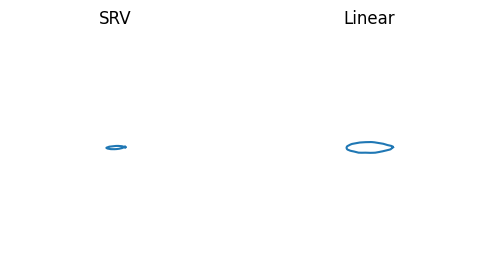

In [30]:
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(121)
metric = 'SRV'
plt.plot(mean_estimate_aligned[metric][:, 0], mean_estimate_aligned[metric][:, 1])
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.title("SRV")
plt.axis("off")

fig.add_subplot(122)
metric = 'Linear'
plt.plot(mean_estimate_aligned[metric][:, 0], mean_estimate_aligned[metric][:, 1])
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.title("Linear")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "global_mean.svg"))
# plt.savefig(os.path.join(figs_dir, "global_mean.pdf"))



# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their  cell line. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [31]:
metric = 'SRV'
dists_to_global_mean = {}
dists_to_global_mean_list = {}
print(mean_estimate_aligned[metric].shape)

dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align[metric], 
    func=lambda x: CURVES_SPACE_SRV.metric.dist(x, mean_estimate_aligned[metric])
)

dists_to_global_mean_list[metric] = []

for l in LINES:
    dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][l])

(1999, 2)


Compute distances to linear mean

In [32]:
metric = 'Linear'
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align[metric], func=lambda x: gs.linalg.norm(mean_estimate_aligned[metric] - x) 
)

dists_to_global_mean_list[metric] = []
for l in LINES:
    dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][l])

Put distances to the global mean using SRV and Linear distance together

[0.01907439 0.04768597 0.05722316 0.09537194 0.09537194 0.10173007
 0.09537194 0.04450691 0.04132784 0.05722316 0.02861158 0.01271626
 0.         0.00953719 0.         0.00317906 0.         0.
 0.         0.00317906]
[13.72155259 15.12582904 16.53010549 17.93438194 19.33865839 20.74293484
 22.14721129 23.55148774 24.95576419 26.36004064 27.76431709 29.16859353
 30.57286998 31.97714643 33.38142288 34.78569933 36.18997578 37.59425223
 38.99852868 40.40280513 41.80708158]


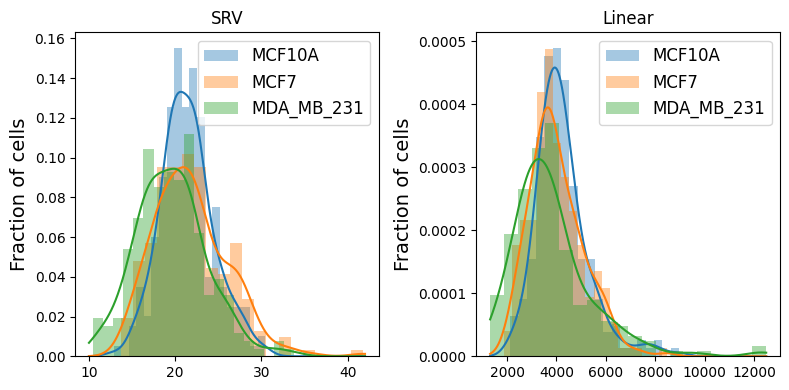

In [33]:
fig, axs = plt.subplots(1, len(METRICS), sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

for i, metric in enumerate(METRICS):
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)

    for j, line in enumerate(LINES):
        distances = dists_to_global_mean[metric][line][
            ~gs.isnan(dists_to_global_mean[metric][line])
        ]

        color = f"C{j}"
        counts, bin_edges, _  = axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=line
        )
        if line == 'MCF7' and metric == 'SRV':
            print(counts)
            print(bin_edges)
        kde = stats.gaussian_kde(distances)
        axs[i].plot(xx, kde(xx), color=f"C{j}")

    axs[i].set_title(f"{metric}")
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

# fig.suptitle("Fig 1: Distances to the global mean")
# plt.savefig(os.path.join(figs_dir, "histogram.svg"))
# plt.savefig(os.path.join(figs_dir, "histogram.pdf"))


Conduct T-test to test if the two samples have the same expected average

In [34]:
for metric in METRICS:
    for i in range(len(LINES)):
        for j in range(i+1, len(LINES)):
            line_1 = LINES[i]
            line_2 = LINES[j]
            distance1 = dists_to_global_mean[metric][line_1][
                ~gs.isnan(dists_to_global_mean[metric][line_1])]
            distance2 = dists_to_global_mean[metric][line_2][
                ~gs.isnan(dists_to_global_mean[metric][line_2])]
            t_statistic, p_value = stats.ttest_ind(distance1, distance2)
            print(f"Significance of differences between {line_1} and {line_2} using {metric} metric is: {'%.2e' % Decimal(p_value)}")

Significance of differences between MCF10A and MCF7 using SRV metric is: 2.23e-01
Significance of differences between MCF10A and MDA_MB_231 using SRV metric is: 1.04e-07
Significance of differences between MCF7 and MDA_MB_231 using SRV metric is: 2.32e-08
Significance of differences between MCF10A and MCF7 using Linear metric is: 3.15e-02
Significance of differences between MCF10A and MDA_MB_231 using Linear metric is: 2.57e-03
Significance of differences between MCF7 and MDA_MB_231 using Linear metric is: 1.81e-01


# Visualization of the Mean of each Cell Line

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

We calculate SRV mean

In [35]:
mean_line_cells = {}
metric = 'SRV'
mean_line_cells[metric] = {}
for line in LINES:
    line_cells = []
    line_cells.extend(ds_align[metric][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(gs.array(line_cells))))
    mean_line_cells[metric][line] = mean_estimator.estimate_

We then calculate linear mean.

In [36]:
metric = 'Linear'
mean_line_cells[metric] = {}
for line in LINES:
    mean_line_cells[metric][line] = gs.mean(ds_align[metric][line], axis=0)

While the mean shapes of the control groups (for both cell lines) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell lines)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.
- there might be some issue with the reparameterization for the MCF10A cell line as shown by the x shape structure.

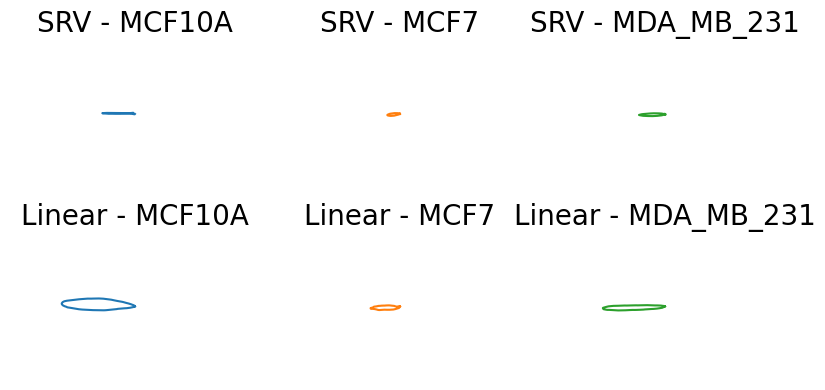

In [37]:
fig, axes = plt.subplots(
    nrows= len(METRICS),
    ncols= len(LINES),
    figsize=(2.7 * len(LINES), 2 * len(METRICS)),
)

for i, metric in enumerate(METRICS):
    for j, line in enumerate(LINES):
        ax = axes[i, j]
        mean_cell = mean_line_cells[metric][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C"+str(j))
        ax.set_xlim(-radius, radius)
        ax.set_ylim(-radius, radius)
        ax.axis("off")
        ax.set_title(f"{metric} - {line}", fontsize=20)
plt.tight_layout()
# plt.suptitle(f"Quantiles for SRV metric using own mean", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "own_mean.svg"))
# plt.savefig(os.path.join(figs_dir, "own_mean.pdf"))

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [38]:
dists_to_own_mean = {}
nan_ids = {}

for metric in METRICS:
    dists_to_own_mean[metric] = {}
    for line in LINES:
        dists = []
        ids = []
        for i_curve, curve in enumerate(ds_align[metric][line]):
            if metric == 'SRV':
                one_dist = CURVES_SPACE_SRV.metric.dist(curve, mean_line_cells[metric][line])
            elif metric == 'Linear':
                one_dist = gs.linalg.norm(curve - mean_line_cells[metric][line])
            dists.append(one_dist)
        dists_to_own_mean[metric][line] = dists


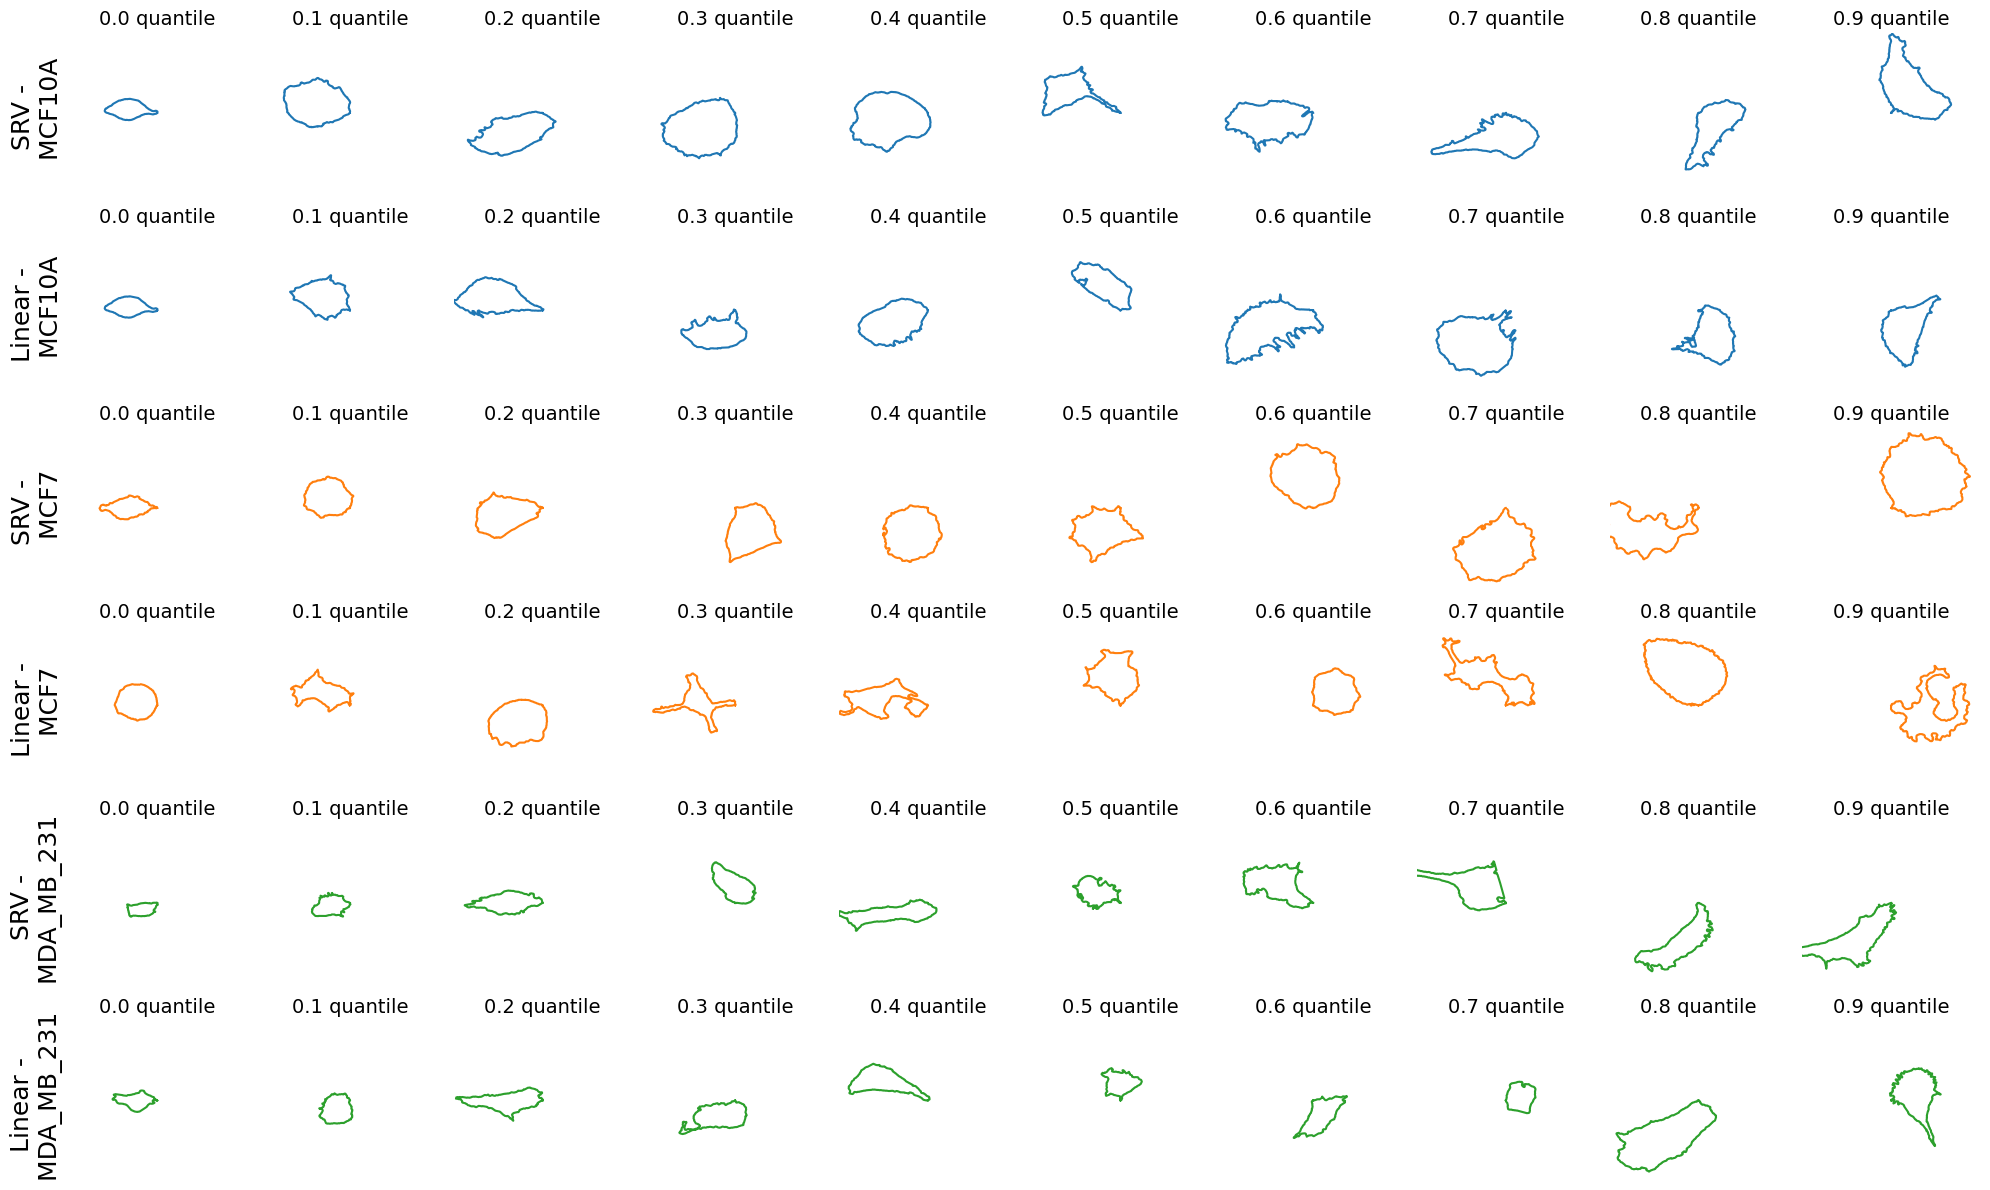

In [39]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows= len(LINES)*len(METRICS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(LINES)*len(METRICS)),
)

for i, line in enumerate(LINES):
    for j, metric in enumerate(METRICS):
        dists_list = dists_to_own_mean[metric][line]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[metric][line])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2*i+j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.set_xlim(-radius, radius)
            ax.set_ylim(-radius, radius)
            if i_quantile == 0:
                ax.set_ylabel(f"{metric} - \n {line}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "quantile.svg"))
# plt.savefig(os.path.join(figs_dir, "quantile.pdf"))

The above code find a given number of quantiles within the distance's histogram, using linear metric and own mean, and plots the corresponding cell, for each cell line.

In comparison to using the SRV metric, we observe there exists more irregular cells in the lower quantiles.

# Dimensionality Reduction

We use the following experiments to illustrate how SRV metric can help with dimensionality reduction 

In [40]:
mds = {}
pos = {}
dims = range(2, 11)
stresses = {}

for metric in METRICS:
    mds[metric] = {}
    pos[metric] = {}
    stresses[metric] = []
    for dim in dims:

        mds[metric][dim] = manifold.MDS(n_components=dim, random_state=10, dissimilarity="precomputed") # random_state set to 10
        pos[metric][dim] = mds[metric][dim].fit(pairwise_dists[metric]).embedding_
        stress_val = mds[metric][dim].stress_
        scaled_stress_val = np.sqrt(stress_val/((pairwise_dists[metric]**2).sum()/2))

        print(f"the unscaled stress for {metric} model is for {dim}:", stress_val)
        stresses[metric].append(scaled_stress_val)

the unscaled stress for SRV model is for 2: 7.404942090577844
the unscaled stress for SRV model is for 3: 4.9006535134366995
the unscaled stress for SRV model is for 4: 3.656485939277792
the unscaled stress for SRV model is for 5: 2.926702187334013
the unscaled stress for SRV model is for 6: 2.447342712681559
the unscaled stress for SRV model is for 7: 2.1290427572155077
the unscaled stress for SRV model is for 8: 1.8853947422939366
the unscaled stress for SRV model is for 9: 1.6827420844180343
the unscaled stress for SRV model is for 10: 1.5604110449270332
the unscaled stress for Linear model is for 2: 3312.419954853643
the unscaled stress for Linear model is for 3: 1278.8800308974735
the unscaled stress for Linear model is for 4: 488.6490957032187
the unscaled stress for Linear model is for 5: 320.1765507763365
the unscaled stress for Linear model is for 6: 261.9809181446888
the unscaled stress for Linear model is for 7: 242.96811349596015
the unscaled stress for Linear model is for 

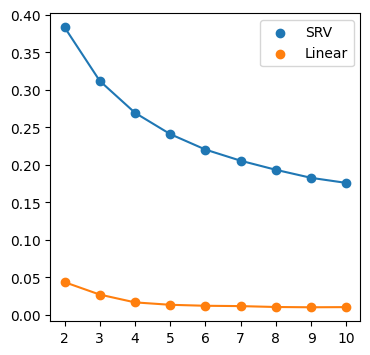

In [41]:
plt.figure(figsize = (4,4))
for metric in METRICS:
    plt.scatter(dims, stresses[metric], label=metric)
    plt.plot(dims, stresses[metric])
plt.xticks(dims)
plt.legend()
# plt.savefig(os.path.join(figs_dir, f"MDS_stress_{suffix}.svg"))
# plt.savefig(os.path.join(figs_dir, f"MDS_stress_{suffix}.pdf"))

In terms of the scaled stress statistics, we observe linear metric perform better than SRV metric. That is, linear metric preserves the pairwise distances in embedded dimension better than the SRV metric.

Calculate MDS statistics for dimension 2

In [42]:
from sklearn import manifold

metric = 'SRV'
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_

Obtain MDS embedding of different cell lines

In [43]:
embs = {}
embs[metric] = {}
index = 0

for line in LINES:
    cell_num = len(ds_align[metric][line])   
    embs[metric][line] = pos[index:index+cell_num]
    index += cell_num

We draw a comparison with linear metric using the following code

In [44]:
metric = 'Linear'
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_


In [45]:
embs[metric] = {}
index = 0

for line in LINES:
    cell_num = len(ds_align[metric][line])   
    embs[metric][line] = pos[index:index+cell_num]
    index += cell_num

If we can make a better interpretation of the visual result of SRV metric, we could still argue SRV is better at capturing cell heterogeneity. 

Plot SRV and linear metric dimension reduction side by side

Text(0.5, 0.98, 'MDS of cell shapes in 2D for breast cancer dataset')

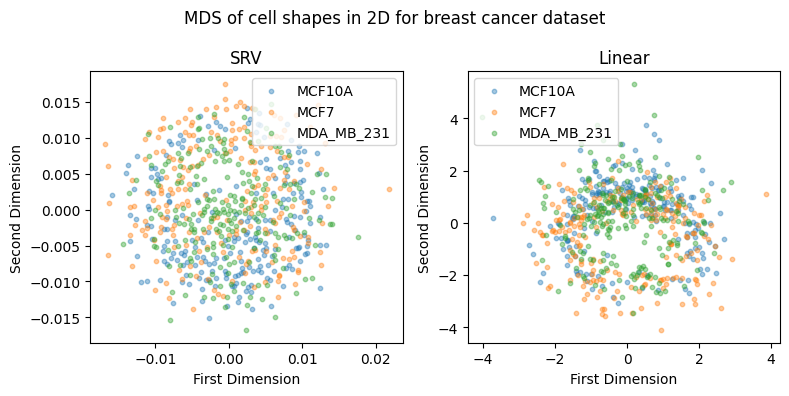

In [46]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))


for j, metric in enumerate(METRICS):
    for i, line in enumerate(LINES):
        cur_embs = embs[metric][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                s=10,
                alpha=0.4,
                label=line
            )
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")


fig.suptitle("MDS of cell shapes in 2D for breast cancer dataset")


We observe that when it comes to dimension reduction, using SRV metric does not separate different cell lines better than using the linear metric.

We also consider embedding in 3D. 

In [47]:
metric = 'SRV'
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_

In [48]:
embs = {}
embs[metric] = {}
index = 0
for line in LINES:
    cell_num = len(ds_align[metric][line])   
    embs[metric][line] = pos[index:index+cell_num]
    index += cell_num

In [49]:
metric = 'Linear'
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_


In [50]:
embs[metric] = {}
index = 0
for line in LINES:
    cell_num = len(ds_align[metric][line])   
    embs[metric][line] = pos[index:index+cell_num]
    index += cell_num

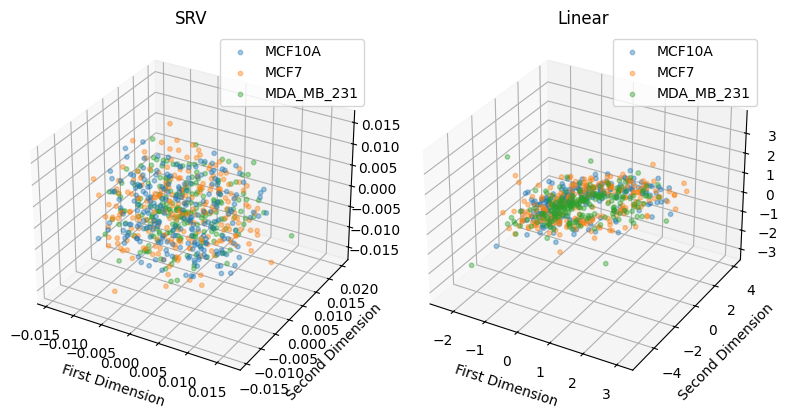

In [51]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

for j, metric in enumerate(METRICS):
    for i, line in enumerate(LINES):
        cur_embs = embs[metric][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=line,
                alpha=0.4,
                s=10
            )
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=10)


plt.tight_layout()
# plt.show()

# Multi-class (3 class) classification

We now consider one cell line at the same time, to investigate the effects of the drugs on the cell shapes. Applying the MDS again gives the following results.

Since the detected subspace dimension for this dataset is 3, we perform the classification based on 3D embeddings.

In [52]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def svm_5_fold_classification(X, y):
    # Initialize a Support Vector Classifier
    svm_classifier = svm.SVC(kernel='poly', degree=4)

    # Prepare to split the data into 5 folds, maintaining the percentage of samples for each class
    skf = StratifiedKFold(n_splits=5)
    
    # To store precision and recall per class for each fold
    precisions_per_class = []
    recalls_per_class = []
    accuracy_per_class = []

    # Perform 5-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        # Splitting data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        svm_classifier.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred = svm_classifier.predict(X_test)

        # Calculate precision and recall per class
        precision = precision_score(y_test, y_pred, average=None, zero_division=np.nan)
        recall = recall_score(y_test, y_pred, average=None, zero_division=np.nan)
        accuracy = accuracy_score(y_test, y_pred)

        # Store results from each fold
        precisions_per_class.append(precision)
        recalls_per_class.append(recall)
        accuracy_per_class.append(accuracy)
    
    # Calculate the mean precision and recall per class across all folds
    mean_precisions = np.mean(precisions_per_class, axis=0)
    mean_recalls = np.mean(recalls_per_class, axis=0)
    mean_accuracies = np.mean(accuracy_per_class, axis=0)

    np.set_printoptions(precision=2)
    
    print("Mean precisions per class across all folds:", mean_precisions)
    print("Mean recalls per class across all folds:", mean_recalls)
    print("Mean accuracies per class across all folds:", round(mean_accuracies, 2))

    return mean_precisions, mean_recalls

In [53]:
lines = gs.array(lines)
print(LINES)

['MCF10A' 'MCF7' 'MDA_MB_231']


In [54]:

for metric in METRICS:
    MCF10A_indexes = gs.where(lines == 'MCF10A')[0]
    MCF7_indexes = gs.where(lines == 'MCF7')[0]
    MDA_MB_231_indexes = gs.where(lines == 'MDA_MB_231')[0]

    indexes = gs.concatenate((MCF10A_indexes, MCF7_indexes, MDA_MB_231_indexes))
    matrix = pairwise_dists[metric][indexes][:, indexes]

    mds = manifold.MDS(n_components=3, random_state = 10, dissimilarity="precomputed")
    pos = mds.fit(matrix).embedding_

    line_strings, line_labels = np.unique(lines, return_inverse=True)

    print(f"Using {metric} on {line}")
    svm_5_fold_classification(pos, line_labels)


Using SRV on MDA_MB_231
Mean precisions per class across all folds: [0.43 0.37 0.56]
Mean recalls per class across all folds: [0.28 0.76 0.15]
Mean accuracies per class across all folds: 0.4
Using Linear on MDA_MB_231
Mean precisions per class across all folds: [0.34 0.45 0.44]
Mean recalls per class across all folds: [0.58 0.35 0.1 ]
Mean accuracies per class across all folds: 0.35
